In [903]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [904]:
# Parameters
n = 30
C = 4

# CSV name
csv_name = "Slow_New"

In [905]:
CSV = pd.read_csv(f"{csv_name}.csv").fillna(1.0)
CSV_Vector = CSV[CSV["type"] == "vector"]


In [906]:

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:vector"]

# Dictionary for containing all the DataFrames
CSV_Dict = {
    "W": Exp_W,
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in Exp_W.iterrows():
    # The key of config is the run number and the value is the configuration p_K
    config[row["run"].split("-")[1]] = "BASE"


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is the configuration p_K
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific configuration

        # In row we save the run number
        run = row["run"].split("-")[1]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            
            if key == "W":
                PI[key][config[run]][run][string] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 
        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            # For the current run we save the PI value of the overall system
            PI[key][config[run]][run] = float(row["value"])

# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific configuration
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [907]:
PI_df["W"]["BASE"]


,Q0,Q1,Q2,Q3
0,0 0 0 0 0 0 0 0 0 0 28.578878672095 0 0 0 3.90...,0 0 0 0 0 0 0,0 12.086376690964 626.73053120812 152.61771614...,0 0 577.19875719182 120.17143222851 40.6783134...
1,0 0 28.864441071405 5.126790529929 0 0 0 0 0 2...,0 19.065697051869 0 0 7.11494393862 0 0 0,0 397.59897372214 415.48372324786 380.87568547...,0 0 415.23934431055 549.79473947526 350.094963...
2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6.49447606138 ...,0 0 0 0 0 0,0 62.602709981915 100.32999808574 0 41.4355356...,0 447.44454736196 565.87773974917 97.754010197...
3,0 3.185794966688 0 0 0 0 33.731757559888 2.059...,0 0 0 0 0 0 0 0 0 0 0,0 66.504317862645 100.34584513036 242.53832373...,0 119.54569841395 150.92092433434 52.070483007...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6.188611496456...,0 0 0 0 0 0 0,0 144.54054391752 50.707376857485 215.16705173...,0 201.57600254304 315.86853403332 331.18401116...
5,0 0 0 0 18.078370852929 0 0 31.483821594594 0 ...,0 0 0 0 0 0 0,0 32.951688036213 0 0 78.272448104024 115.6135...,0 198.33390033641 257.99679241712 170.84876947...
6,0 0 7.131738091006 0 0 11.305593361474 0 0 0 0...,0 0 0 0 0 0,0 26.753169154286 163.74902839125 0 37.3127146...,0 0 463.27714458683 154.66035893201 202.118505...
7,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29...,0 0 0 0,0 123.52577430074 59.603928436131 122.08369884...,0 77.205594755386 0 218.87354480295 0 22.43471...
8,0 19.081469840756 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 41.027258992155 0,0 222.07471906351 0 0 99.446915825469 78.63346...,0 101.74183926514 0 2.337639705081 3.750816895...
9,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0,0 15.56274494817 0 33.872200140946 0 0 66.8782...,0 0 208.76955119412 290.50774504067 118.958769...


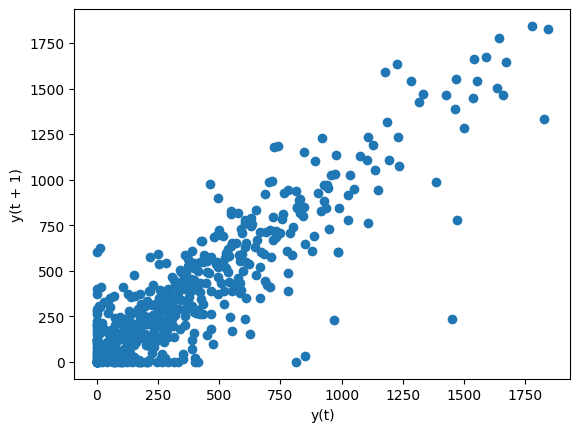

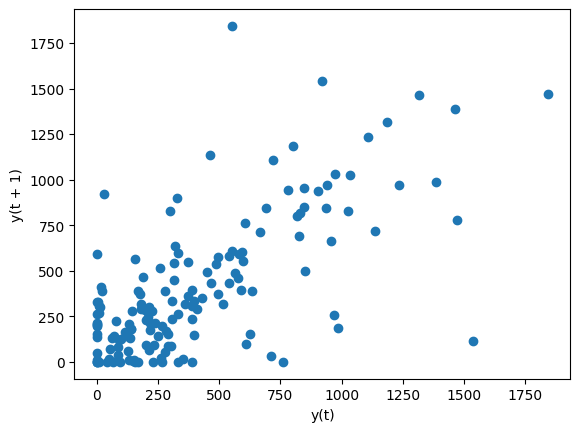

In [908]:
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot

for _, row in PI_df["W"]["BASE"].iterrows():
    prova = row["Q2"].split(" ")
    prova = [float(i) for i in prova]
    prova = pd.DataFrame(prova)
    lag_plot(prova)
    plt.show()
    subsample = prova.sample(frac=0.3)
    subsample.sort_index(inplace=True)
    lag_plot(subsample)
    plt.show()
    # sns.distplot(prova, hist=False, rug=True)
    break

In [909]:
for index, row in PI_df["W"]["BASE"].iterrows():
    for q in Q:
        values = row[q].split(" ")
        values = [float(i) for i in values]
        values = pd.DataFrame(values)
        subsample = values.sample(frac=0.3)
        # subsample.sort_index(inplace=True)
        PI_df["W"]["BASE"].loc[index, q] = subsample.mean()[0]


# values = values.tolist()[0].split(" ")
# values = [float(i) for i in values]
# values = np.array(values)
# values = pd.DataFrame(values)
# values.mean(), values.std()

# sub = values.sample(frac=0.4)
# sub.sort_index(inplace=True)
# sub.mean(), sub.std()
# subsample.mean()[0], values.mean()

C:\Users\giova\AppData\Local\Temp\ipykernel_13076\4206291307.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(PI_df["W"]["BASE"]["Q1"], hist=False, rug=True, label="Q1")


<Axes: xlabel='Q1', ylabel='Density'>

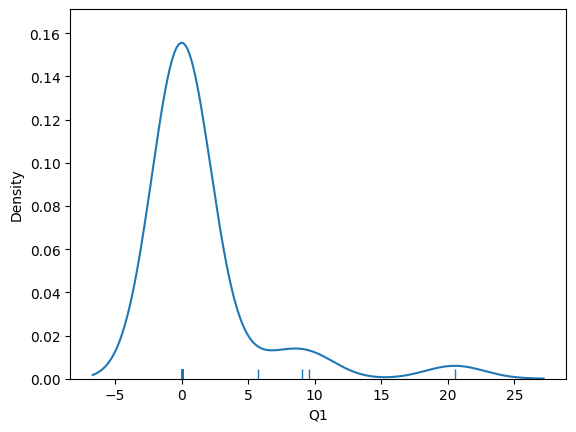

In [910]:
sns.distplot(PI_df["W"]["BASE"]["Q1"], hist=False, rug=True, label="Q1")

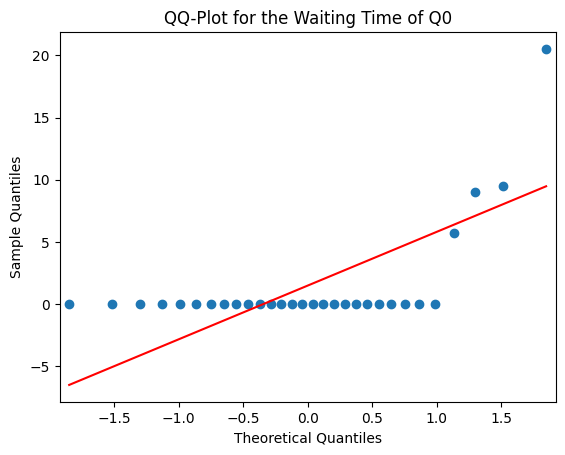

In [911]:
from statsmodels.graphics.gofplots import qqplot
import numpy as np
# Plot QQ-Plot for the Waiting Time of Q0
import matplotlib.pyplot as plt

qqplot(PI_df["W"]["BASE"]["Q1"], line='s')
plt.title('QQ-Plot for the Waiting Time of Q0')
plt.show()